# Introduction to Cross Validation and Model Selection

In a previous lab you created a model with l2 or ridge regularization and l1 or lasso regularization. In both cases, an apparently optimum value of the regularization parameter was found. This process is an example of **model selection**. The goal of model selection is to find the best performing model for the problem at hand. Model selection is a very general term and can apply to at least the following common cases:
- Selection of optimal model **hyperparameters**. Hyperparameters are parameters which determine the characteristics of a model. Hyperparameters are distinct from the model parameters. For example, for the case of l2 regularized regression, the degree of regularization is determined by a hyperparameter, which is distinct from the regression coefficients or parameters. 
- **Feature selection** is the process of determining which features should be used in a model. 
- Comparing different model types is an obvious case of model selection. 

If you are thinking that the model selection process is closely related to model training, you are correct. Model selection is a component of model training. However, one must be careful, as applying a poor model selection method can lead to an over-fit model!

## Overview of k-fold cross validation

The questions remain, how good are the hyperparameter estimates perviously obtained for the l2 and l1 regularization parameters and are there better ways to estimate these parameters? The answer to both questions is to use **resampling methods**. Resampling methods repeat a calculation multiple times using randomly selected subsets of the complete dataset.  In fact, resampling methods are generally the best approach to model selection problems. 


**K-folod Cross validation** is a widely used resampling method. In cross validaton a dataset is divided into **k folds**. Each fold contains $\frac{1}{k}$ cases and is created by **Bernoulli random sampling** of the full data set. A computation is performed on $k-1$ folds of the full dataset. The $k^{th}$ fold is **held back** and is used for testing the result. The compuation is performed $k$ times and model parameters are averaged (mean taken) over the results of the $k$ folds. For each iteration, $k-1$ folds are used for training and the $k^{th}$ fold is used for testing. 

4-fold cross validation is illustrated in the figure below. To ensure the data are randomly sampled the data is randomly shuffled at the start of the procedure. The random samples can then be efficiently sub-sampled as shown in the figure. The model is trained and tested four times. For each iteration the data is trained with three folds of the data and tested with the fold shown in the dark shading. 

<img src="img/CrossValidation.jpg" alt="Drawing" style="width:750px; height:400px"/>
<center> **Resampling scheme for 4-fold cross validation**</center>

## Introduction to nested cross validation

Unfortunately, simple cross validation alone does not provide an unbiased approach to model selection. The problem with evaluating model performance with simple cross validation uses the same data samples as the model selection process. This situation will lead to model over fitting wherein the model selection is learned based on the evaluation data. The result is usually unrealistically optimistic model performance estimates.

To obtain unbiased estimates of expected model performance while performing model selection, it is necessary to use **nested cross validation**. As the name implies, nested cross validation is performed though a pair of nested CV loops. The outer loop uses a set of folds to perform model evaluation. The inner loop performs model selection using another randomly sampled set of  folds not used for evalution by the outer loop. This algorithm allows model selection and evaluation to proceed with randomly sampled subsets of the full data set, thereby avoiding model selection bias. 

## Cross validation and compuational efficiency

As you may have surmised, cross validation can be compuationally intensive. Processing each fold of a cross validation requires fitting and evaluating the model. It is desireable to compute a reasonable number of folds. Since the results are averaged over the folds, a small number of folds can lead to significant variablity in the final result. However, with large data sets or complex models, the number of folds must be limited in order to complete the cross validation process in a reasonable amount of time. It is, therefore, necessary to trade off accuracy of the cross validation result with the practical consideration of the required compuatational resources. 

As mentioned earlier, other resampling methods exist. For example, leave-one-out resampling has the same number of folds as data cases. Such methods provide optimal unbiased estimates of model performance. Unfortunately, as you might think, such methods are compuationally intensive and are only suitable for small datasets. In practice k-fold cross validation is a reasonable way to explore bias-variance trade-off with reasonable compuational resources. 

### Load Features and Labels

With the above theory in mind, you will now try an example. 

As a first step, execute the code in the cell below to load the packages required for this notebook. 

In [47]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)
library(glmnet)
library(ROCR)

options(repr.plot.width=5, repr.plot.height=5) # Set the initial plot area dimensions

Next, load the preprocessed files containing the features and the labels. The preprocessing includes the following:
1. Cleaning missing values.
2. Aggregate categories of certain categorical variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [48]:
credit = read.csv('German_Credit_Preped.csv')
print(dim(credit))
names(credit)

[1] 999  23


[1] "X"                        "Customer_ID"             
 [3] "checking_account_status"  "loan_duration_mo"        
 [5] "credit_history"           "purpose"                 
 [7] "loan_amount"              "savings_account_balance" 
 [9] "time_employed_yrs"        "payment_pcnt_income"     
[11] "gender_status"            "other_signators"         
[13] "time_in_residence"        "property"                
[15] "age_yrs"                  "other_credit_outstanding"
[17] "home_ownership"           "number_loans"            
[19] "job_category"             "dependents"              
[21] "telephone"                "foreign_worker"          
[23] "bad_credit"

## Split the dataset

You must now create randomly sampled training and test data sets. The `createDataPartition` function from the R caret package is used  to create indices for the training data sample. Execute this code and note the dimensions of the resulting data frame.

In [49]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(credit[,'bad_credit'], times = 1, p = 0.7, list = FALSE)
training = credit[partition,] # Create the training sample
dim(training)
test = credit[-partition,] # Create the test sample
dim(test)

[1] 700  23

[1] 299  23

## Scale numeric features

Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables. 

The code in the cell below uses the `preProcess` function from the caret function. The processing is as follows:
1. The preprocessing model object is computed. In this case the processing includes centering and scaling the numeric feature. Notice that this model is fit only ot the training data.
2. The scalling is appled both the test and training partitions.

Execute the code. 

In [50]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2422240,0.9130877,-0.8632953,-0.7888462,-1.20616846,-0.7009378,-0.429150
-0.7420395,-0.4105541,-0.8632953,0.1208611,1.25859356,-0.7009378,2.326859
1.7448468,1.5761103,-0.8632953,1.0305684,0.89344363,-0.7009378,2.326859
0.2527150,0.5419186,0.0319739,1.0305684,1.62374349,1.0768031,2.326859
1.2474695,1.9788682,-0.8632953,1.0305684,-0.01943119,-0.7009378,2.326859
0.2527150,-0.1568132,0.0319739,1.0305684,1.62374349,-0.7009378,-0.429150


## Construct the logistic regression model

To create a baseline for comparison you will now create a logistic regression model without cross validation. This model uses a fixed set of hyperparameters. You will compare the performance of this model with the cross validation results computed subsequently. 

Now, it is time to compute the logistic regression model. The code in the cell below does the following:
1. Define a logistic regression model object using the R generalized linear model or `glm` method. The folowing arguments a are used:
  - An R model formula. 
  - Weights for the cases to help compensate of the class imbalance.
  - The distribution family of the response is specified as `quasibinomial`. A quasibinomial distribution is similar to a binomial distribution but accounts for greater dispursion or larger errors. 
  -
2. The `predict` method is used to compute the log-likelihoods for each case in the test data.
3. A threshold is applied to the log-likelihoods to compute categorical scores.

Execute this code. 

In [51]:
score_model = function(df, threshold){
    df$score = ifelse(df$probs > threshold, 1, 0)
    df
}

## Create a weight vector for the training cases.
weights = ifelse(training$bad_credit == 1, 0.66, 0.34)

set.seed(5566)
logistic_mod = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                    weights = weights,
                    family = quasibinomial, data = training)

test$probs = predict(logistic_mod, newdata = test, type = 'response')
test = score_model(test, 0.5)
test[1:20, c('bad_credit','score', 'probs')]

,bad_credit,score,probs
13,1,1,0.55602394
14,0,1,0.74821455
17,0,1,0.92552325
19,0,0,0.21258303
21,0,0,0.26270505
22,0,0,0.23380177
23,0,0,0.10091975
29,1,1,0.80682452
30,0,0,0.44129136
39,0,0,0.25283724


You can see the log-likelihoods in the right column, the scores in the center column and the labels on the left. A number of errors in the classification are evident. 

The code in the cell below computes and displays metrics and the ROC curve for the model using the test data subset. This code follows the same receipe used in pervious labs. Execute this code and examine the results. 

        Negative Positive
TrueNeg      163       56
TruePos       27       53

accuracy  = 0.722 
precision = 0.486 
recall    = 0.662 
F1        =  0.561 


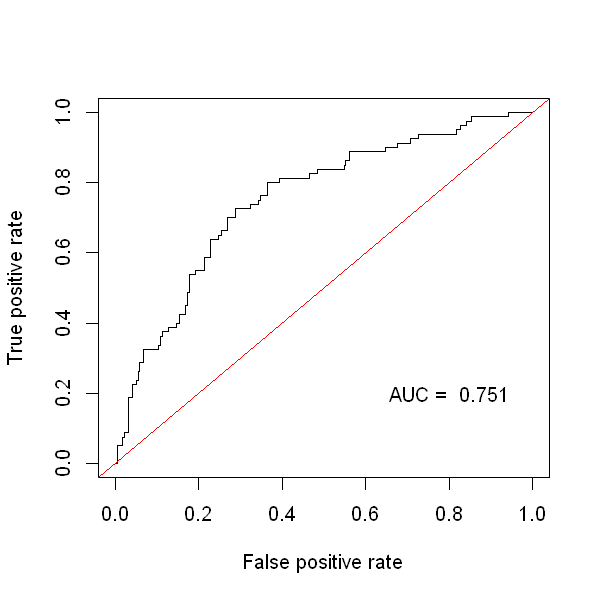

In [52]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('TrueNeg', 'TruePos')
  print(out)  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R)  
  cat('\n')
  cat(paste('accuracy  =', as.character(round((TP + TN)/(TP + TN + FP + FN), 3)), '\n'))      
  cat(paste('precision =', as.character(round(P, 3)), '\n'))     
  cat(paste('recall    =', as.character(round(R, 3)), '\n'))
  cat(paste('F1        = ', as.character(round(F1,3)),'\n'))
}

ROC_AUC = function(df){
    options(repr.plot.width=5, repr.plot.height=5)
    pred_obj = prediction(df$probs, df$bad_credit)
    perf_obj <- performance(pred_obj, measure = "tpr", x.measure = "fpr")
    AUC = performance(pred_obj,"auc")@y.values[[1]] # Access the AUC from the slot of the S4 object
    plot(perf_obj)
    abline(a=0, b= 1, col = 'red')
    text(0.8, 0.2, paste('AUC = ', as.character(round(AUC, 3))))
}

logistic.eval(test)
ROC_AUC(test)

These results look promisting, with most of the metrics having resonable values. The question is now, how will these performance estimates hold up to cross validaton?

## Cross validate model

To compute a better estimate of model performance, you can perform simple cross validation. The code in the cell performs the following processing:
1. The `binary.eval` function returns a data frame with a single row, containing the performance metrics for the fold being evaluated. This code is similar to evaluation code used previously. 
2. The `Create_Folds` function creates a vector of fold numbers with equal numbers of cases in each fold. The result is an integer index used to determine which case belong to each fold. 
3. The `Fit_Mod` function is called when training and scoring the model for each fold of the CV. The arguments are the training and test data sets for each fold along with the training case weights. 
4. The `Cross_Validate_Mod` function performs the following operations:
 - The fold indices are computed.
 - The data frame is randomly suffled to ensure the fold are randomized.
 - A loop over the folds of the CV calls the `Fit_Mod` function with training and test data partitions determined by the fold indices. 
 - Summary statistics for the CV are computed and appended to the data frame. 
 - The data frame is returned by the function. 

Execute this code. 

In [53]:
binary.eval <- function(df, fold){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf = ifelse(df$bad_credit == 1 & df$score == 1, 'TP',
                    ifelse(df$bad_credit == 0 & df$score == 1, 'FP',
                           ifelse(df$bad_credit == 0 & df$score == 0, 'TN', 'FN')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
  
  ## Confusion matrix as data frame
  out = data.frame(Negative = c(TN, FN), Positive = c(FP, TP))
  row.names(out) = c('TrueNeg', 'TruePos')
    
  # Compute AUC with ROCR package
  pred_obj = prediction(df$probs, df$bad_credit)
  AUC = performance(pred_obj,"auc")@y.values[[1]]  
  
  # Compute and print metrics
  P = TP/(TP + FP)
  R = TP/(TP + FN)  
  F1 = 2*P*R/(P+R) 
  data.frame = data.frame(fold = as.character(fold),
                          accuracy = (TP + TN)/(TP + TN + FP + FN),
                          precision = P,
                          recall = R,
                          F1 = F1,
                          AUC = AUC)
 }


Create_Folds = function(df, folds){
    ## Create a vector of the fold assignments
    nrows = nrow(df)
    ncount = nrows/folds
    ## Concatenate vectors of fold number
    fold = rep(1, ncount)
    for(i in seq(2, folds, by = 1)){
        fold = c(fold, rep(i, ncount))
    }
    fold
}

Fit_Mod = function(training, test, weights){
    set.seed(5566)
    logistic_mod = glm(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                    weights = weights,
                    family = quasibinomial, data = training)
    test$probs = predict(logistic_mod, newdata = test, type = 'response')
    test = score_model(test, 0.5)
    test
}

Cross_Validate_Mod = function(df, folds){
    ## Create a vector of the fold assignments
    fold = Create_Folds(df, folds)
    
    ## Randomly shuffle the rows of the data frame
    shuffle = sample(seq(1, nrow(df), by = 1))
    df = df[shuffle,]
    
    ## Loop over number of folds to fit and evaluate the model
    training = df[fold != 1,]
    test = df[fold == 1, ]
    test = Fit_Mod(training, test, 
                   weights = ifelse(training$bad_credit == 1, 0.66, 0.34))
    evals = binary.eval(test, 1)
    for(i in seq(2, folds, by = 1)){
        training = df[fold != i,]
        test = df[fold == i, ]
        test = Fit_Mod(training, test, 
                       weights = ifelse(training$bad_credit == 1, 0.66, 0.34))
        evals = rbind(evals, binary.eval(test, i))
    }
    
    ## Compute some summary statistics and append to the data rame
    evals = rbind(evals, data.frame(fold = 'Mean',
                          accuracy = mean(evals[,2]),
                          precision = mean(evals[,3]),
                          recall = mean(evals[,4]),
                          F1 = mean(evals[,5]),
                          AUC = mean(evals[,6])))
    
    evals = rbind(evals, data.frame(fold = 'std',
                          accuracy = sd(evals[,2]),
                          precision = sd(evals[,3]),
                          recall = sd(evals[,4]),
                          F1 = sd(evals[,5]),
                          AUC = sd(evals[,6])))
    evals
}

Cross_Validate_Mod(credit, 10)

fold,accuracy,precision,recall,F1,AUC
1,0.77777778,0.60000000,0.7500000,0.66666667,0.8301809
2,0.69696970,0.61538462,0.4444444,0.51612903,0.7270723
3,0.75757576,0.58823529,0.6666667,0.62500000,0.7942029
4,0.76767677,0.59090909,0.8387097,0.69333333,0.8690702
5,0.71717172,0.57894737,0.6470588,0.61111111,0.7859729
6,0.70707071,0.40540541,0.6818182,0.50847458,0.7880756
7,0.64646465,0.40000000,0.5925926,0.47761194,0.7268519
8,0.69696970,0.57142857,0.6666667,0.61538462,0.7826279
9,0.63636364,0.35483871,0.4074074,0.37931034,0.6723251
10,0.72727273,0.47222222,0.6800000,0.55737705,0.7670270


Notice that there is considerable variability in each of the performance metrics from fold to fold. In several cases the standard deviation is the same order of magnitude as the mean. It is clear that **any one fold does not provide a representative value of the performance metrics**. The later is a key point as to why cross validation is important when evaluating a machine learning model.  

Compare the performance metric values to the values obtained for the baseline model you created above. In general the metrics obtained by cross validation are lower. However, the metrics obtained for the baseline model are mostly within 1 standard deviation of the average metrics from cross validation. 

## Optimize hyperparameters with nested cross validation

Given the variability observed in cross validation, it should be clear that performing model selection from a single training and evauation is an uncertain proposition at best. Fortunately, the nested cross validation approach provides a better way to perform model selection. However, there is no guarantee that a model selection process will, in fact, improve a model. In some cases, it may prove to be that model selection has minimal impact. 

The inner cross validation loop is used to find the optimal hyperparameters. The code in the cell below uses the facilities of the R caret package as follows:
1. The label is transformed to a factor to prevent caret from interpreting the formula as a regression problem.
2. A caret `trainControl` object is created which defines repeated cross validation with 10 folds and 5 repeats. This spcification is compuationally intensive and must be reduced with few folds and repeats for large scale problems. 
3. The caret `train` function is used to train the model, testing combinationns of hyperparameters using cross validation. The model formula, data, model type and trainControl object are all spcified.

Once the inner cross validation determines optimal hyperparameters, a finally cross validation is performed to determine how well the final model is expected to perform. Notice that by creating these independent fold objects there is no need to actually create nested loops for this process. While conceptually nesting the inner and out loops is not hard, it is compuationally intensive and generally avoided. 

Execute this code.

In [54]:
credit[,'bad_credit_factor'] = as.factor(credit[,'bad_credit'])

fitControl = trainControl(method = 'repeatedcv',
                         number = 10,
                         repeats = )5

set.seed(9999)
cv_mod = train(bad_credit_factor ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property,
                 data = credit, 
                 method = "glmnet", 
                 trControl = fitControl)
    
cv_mod

glmnet 

999 samples
 10 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 899, 899, 899, 900, 899, 899, ... 
Resampling results across tuning parameters:

  alpha  lambda       Accuracy   Kappa    
  0.10   0.000296246  0.7535576  0.3587515
  0.10   0.002962460  0.7531556  0.3561388
  0.10   0.029624601  0.7479475  0.3108407
  0.55   0.000296246  0.7534586  0.3585674
  0.55   0.002962460  0.7529576  0.3549473
  0.55   0.029624601  0.7415444  0.2569130
  1.00   0.000296246  0.7534586  0.3588213
  1.00   0.002962460  0.7515596  0.3492048
  1.00   0.029624601  0.7226283  0.1645189

Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were alpha = 0.1 and lambda = 0.000296246.

The model object 

In [55]:
credit[,'bad_credit_factor'] = as.factor(credit[,'bad_credit'])

fitControl = trainControl(method = 'repeatedcv',
                         number = 10,
                         repeats = 5,
                         summaryFunction = recallSummary)

recallSummary = function (data, lev = NULL, model = NULL) {
                    out = recall(data$obs, data$pred)  
                    names(out) <- "recall"
                    out
}

trGrid <-  expand.grid(alpha = c(0.2, 0.5, 0.75, 1.0), 
                       lambda = c(0.05, 0.1, 0.2, 0.3))

set.seed(9999)
cv_mod = train(bad_credit_factor ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property,
                 data = credit, 
                 method = "glmnet", 
                 metric = "recall",
                 trControl = fitControl,
                 tuneGrid = trGrid,
                 weights = ifelse(credit$bad_credit == 1, 0.66, 0.34))
    
cv_mod

glmnet 

999 samples
 10 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 900, 899, 899, ... 
Resampling results across tuning parameters:

  alpha  lambda  recall   
  0.20   0.05    0.8304486
  0.20   0.10    0.8306829
  0.20   0.20    0.8077472
  0.20   0.30    0.7768135
  0.50   0.05    0.8342439
  0.50   0.10    0.8324676
  0.50   0.20    0.7276858
  0.50   0.30    0.6996970
  0.75   0.05    0.8396539
  0.75   0.10    0.8362149
  0.75   0.20    0.6996970
  0.75   0.30    0.6996970
  1.00   0.05    0.8494352
  1.00   0.10    0.8621558
  1.00   0.20    0.6996970
  1.00   0.30    0.6996970

recall was used to select the optimal model using  the largest value.
The final values used for the model were alpha = 1 and lambda = 0.1.

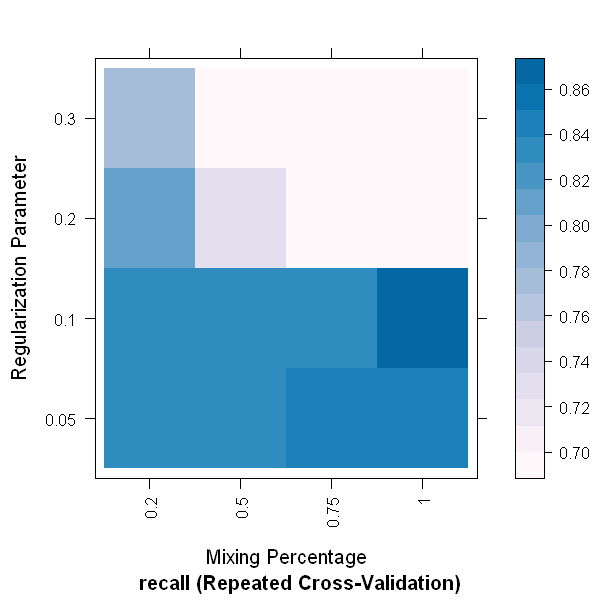

In [56]:
plot(cv_mod, metric = "recall", plotType = "level",
     scales = list(x = list(rot = 90)))

In [57]:
Fit_Mod = function(training, test, weights){
    set.seed(5566)
    x_train = model.matrix(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                           data = training)
    y_train = as.matrix(training[, 'bad_credit'])
    
    
    x_test = model.matrix(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property, 
                           data = test)
    
    logistic_mod = glmnet(x_train, y_train, 
                          weights = weights,
                          alpha = 1.0,
                          lambda = 0.1,
                          family = 'binomial')
    test$probs = predict(logistic_mod, newx = x_test, type = 'response')
    test = score_model(test, 0.5)
    test
}

set.seed(7777)
Cross_Validate_Mod(credit, 10)

fold,accuracy,precision,recall,F1,AUC
1,0.59259259,0.3728814,0.7586207,0.50000000,0.65866434
2,0.73737374,0.5750000,0.7187500,0.63888889,0.82625933
3,0.54545455,0.3387097,0.8400000,0.48275862,0.64297297
4,0.58585859,0.3833333,0.8518519,0.52873563,0.71116255
5,0.54545455,0.3620690,0.7241379,0.48275862,0.63423645
6,0.68686869,0.7058824,0.3157895,0.43636364,0.74978430
7,0.66666667,0.4489796,0.7857143,0.57142857,0.73767606
8,0.69696970,0.5238095,0.6875000,0.59459459,0.76236007
9,0.54545455,0.3606557,0.7857143,0.49438202,0.61820926
10,0.55555556,0.4090909,0.8437500,0.55102041,0.63083022


An important decision in model selection searches is the choice of performance metric used to find the best model. For classification probems Scikit Learn uses accuracy as the default metric. However, as you have seen previously, accuracy is not necessarily the best metric, particularly when there is a class imbalance as is the case here. There are a number of alternatives which one could choose for such a situation. In this case AUC will be used. 

The code below uses the `inside` k-fold object to execute the inside loop of the nested cross validation. Specifically, the steps are:
1. Define a dictionary with the grid of parameter values to search over. In this case there is only one parameter, `C`, with a list of values to try. In a more general case, the dictionary can contain values from multiple parameters, creating a multi-dimensional grid that the cross validation process will iterate over. In this case there are 5 hyperparameter values in the grid and 10-fold cross validation is being used. Thus, the model will be trained and evaluated 50 times. 
2. The logistic regression model object is defined. 
3. The cross validation search over the parameter grid is performed using the `GridSearch` function from the Scikit Learn `model_selection` package. Notice that the cross validation folds are computed using the `inside` k-fold object.


****
**Note:** Somewhat confusingly, the Scikit Learn `LogisticRegression` function uses a regularization parameter `C` which is the inverse of the usual l2 regularization parameter $\lambda$. Thus, the smaller the parameter the stronger the regulation 
****

Execute this code.

The cross validated grid search obect, `clf`, has been creted. 

The code in the cell below fits the cross validated model using the `fit`method. The AUC for each hyperparameter and fold is displayed as an array. Finally, the hyperparameter for the model with the best average AUC is displayed.  Execute this code and  examine the results.

The array of AUC metrics has dimensions 10 folds X  hyperparameter values. As you might expect by now, there is considerable variation in the AUC from fold to fold for each hyperparamter value, or column. 

Evidently, the optimal hyperparameter value is 1.0. 

To help understand this behavior a bit more, the code in the cell below does the following:
1. Compute and display the mean and standard deviation of the AUC for each hyperparameter value.
2. Plot the AUC values for each fold vs. the hyperparameter values. The mean AUC for each hyperparameter value is shown with a red +. 

Execute this code and examine the results. 

There are a number of points to notice here:
1. The mean AUC for each value of the hyperparameter are all within 1 standard deviation of each other. This result indicates that model performance is not sensitive to the choice of hyperparamter. 
2. Graphically you can see that there is a noticeable variation in the AUC from metric to metric, regardless of hyperparameter. Keep in mind that **this variation is simply a result of random sampling of the data!**

Finally, it is time to try execute the outer loop of the nested cross validation to evaluate the performance of the 'best' model selected by the inner loop. In this case, 'best' is quite approximate, since as already noted, the differences in performance between the models is not significant. 

The code in the cell below executes the outer loop of the nested cross validation using the `cross_val_scores` function from the Scikit Learn `model_selection` package. The folds are determined by the `outside` k-fold object. The mean and standard deviation of the AUC is printed along with the value estimated for each fold. Execute this code and examine the result. 

As expected, there is considerable variation in AUC across the folds. The mean AUC is a bit lower than estimated for the inner loop of the nested cross validation and the baseline model. However, all of these values are within 1 standard deviation of each other, and thus these differences cannot be considered significant. 

## Summary

In this lab you have performed by simple cross validation and nested cross validation. Key points and observations are:
1. Model selection should be done using a resampling proceedure such as nested cross validation. The nested sampling structure is required to prevent bias in model selection wherein the model selected learns the best hyperparameters for the samples used, rather than a model that generalizes well. 
2. There is significant variation in model performance from fold to fold in cross validation. This variation arrises from the sampling of the data alone and is not a property of any particular mdoel.
3. Given the expected sampling variation in cross validation, there is generally considerable uncertainty as to which model is best when performing model selection.  